In [1]:
import networkx as nx
import json
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
import community as community_louvain
from collections import Counter

In [14]:
# --- Load POS tags with attributes ---
with open("pos_tags.json", "r", encoding="utf-8") as f:
    pos_tags = json.load(f)


def create_graph(file):
    graph = nx.Graph()
    with open(file, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:  
                continue
            parts = line.split(",")
            if len(parts) != 2:
                continue  
            w1, w2 = parts
            graph.add_edge(w1.strip(), w2.strip())

    # --- Add node attributes from pos_tags ---
    for node in graph.nodes():
        if node in pos_tags:
            graph.nodes[node]["pos"] = pos_tags[node].get("pos")
            graph.nodes[node]["gender"] = pos_tags[node].get("gender")
        else:
            graph.nodes[node]["pos"] = None
            graph.nodes[node]["gender"] = None
    return graph

# --- Create graph ---
G_male = create_graph("male_pairs.txt")
G_female =create_graph("female_pairs.txt")
mixed_graph = create_graph("mixed_pairs.txt")

In [15]:
G_male.number_of_edges(),G_male.number_of_nodes(), G_female.number_of_edges(),G_female.number_of_nodes(), mixed_graph.number_of_edges(),mixed_graph.number_of_nodes()

(255197, 12755, 62471, 5708, 145859, 8410)

In [17]:
def get_max_degree_centrality_node(graph):
    degree_centrality = nx.degree_centrality(graph)

    max_degree_node = max(degree_centrality, key=degree_centrality.get)

    node_name = max_degree_node  
    node_attrs = graph.nodes[max_degree_node]

    print(f"Node with highest degree centrality: {node_name}")
    print(f"Centrality: {degree_centrality[max_degree_node]}")
    print(f"Attributes: {node_attrs}")

get_max_degree_centrality_node(G_male)
get_max_degree_centrality_node(G_female)
get_max_degree_centrality_node(mixed_graph)


Node with highest degree centrality: back
Centrality: 0.11149443311902149
Attributes: {'pos': 'ADV', 'gender': None}
Node with highest degree centrality: jim
Centrality: 0.08498335377606449
Attributes: {'pos': 'PERSON', 'gender': 'female'}
Node with highest degree centrality: back
Centrality: 0.1251040551789749
Attributes: {'pos': 'ADV', 'gender': None}


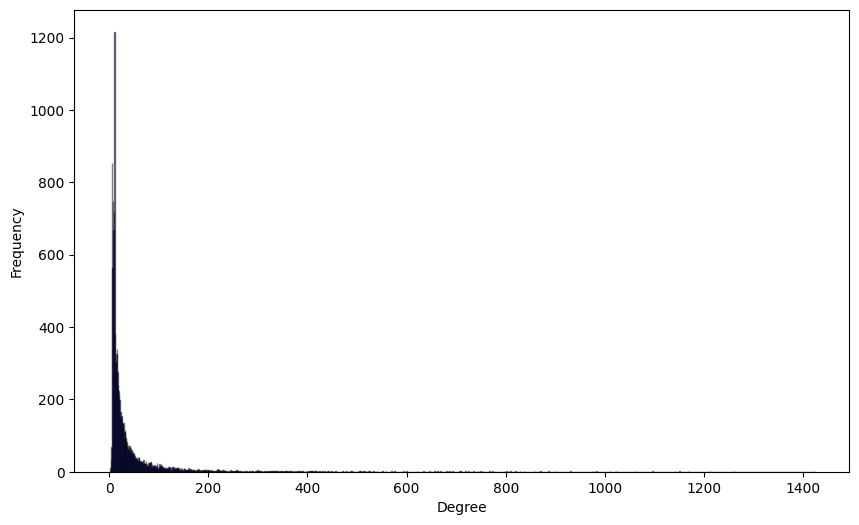

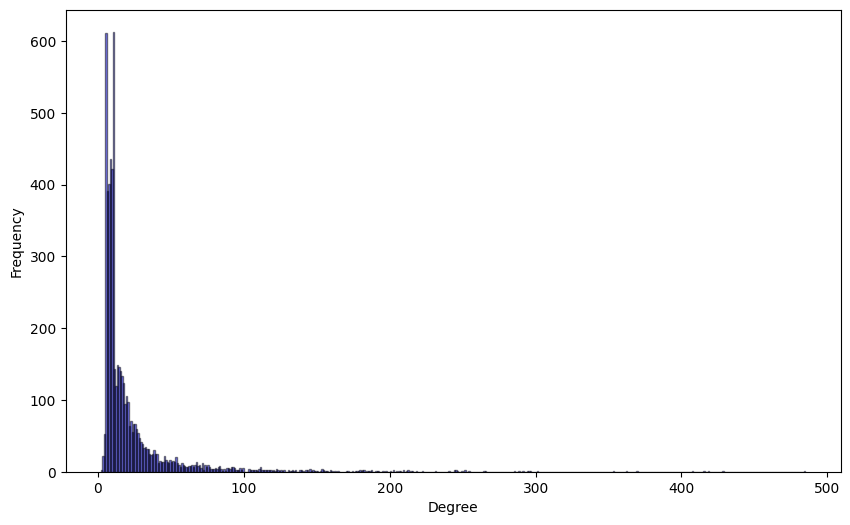

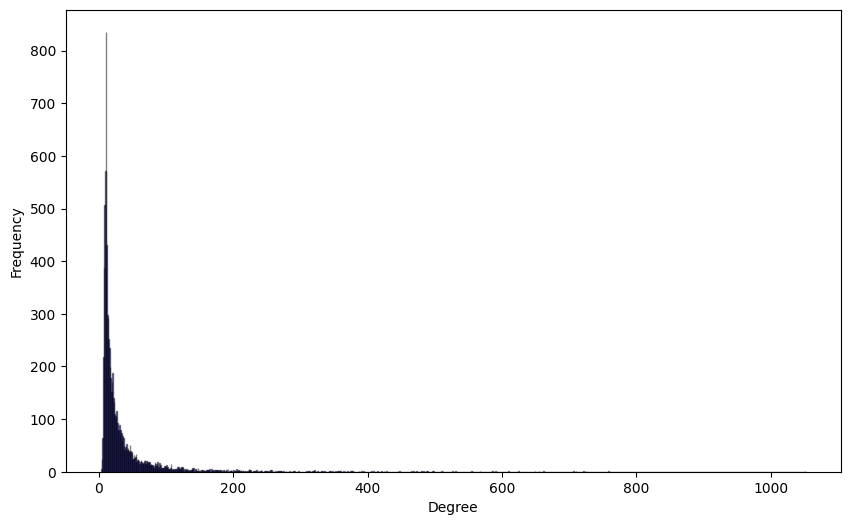

In [18]:
def plot_degree_dist(graph):
    degree = dict(graph.degree())
    min_degree, max_degree = min(degree.values()), max(degree.values())
    degree_vector = np.arange(min_degree, max_degree + 1)
    degree_hist = np.histogram(list(degree.values()), bins=degree_vector)

    plt.figure(figsize=(10, 6))
    plt.hist(degree.values(), bins=degree_hist[1], color='blue', alpha=0.5, edgecolor='black')
    # plt.title('Degree Distribution', size=40)
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
plot_degree_dist(G_male)
plot_degree_dist(G_female)
plot_degree_dist(mixed_graph)

In [6]:
sorted(G_male.degree(), key=lambda x: x[1], reverse=True)[:10], sorted(G_female.degree(), key=lambda x: x[1], reverse=True)[:10]

([('back', 1422),
  ('father', 1260),
  ('help', 1211),
  ('named', 1167),
  ('home', 1150),
  ('find', 1141),
  ('new', 1095),
  ('tells', 1062),
  ('family', 1022),
  ('time', 1010)],
 [('jim', 485),
  ('father', 428),
  ('family', 418),
  ('mother', 415),
  ('back', 407),
  ('home', 369),
  ('named', 362),
  ('find', 353),
  ('finds', 301),
  ('take', 296)])

In [19]:
def get_connected_component(graph):
    #get connected components
    connected_components = list(nx.connected_components(graph))
    print(f"Number of connected components: {len(connected_components)}")
    largest_cc = max(connected_components, key=len)
    G_largest = graph.subgraph(largest_cc)
    print(f"Largest connected component size: {G_largest.number_of_nodes()} nodes, {G_largest.number_of_edges()} edges")
    #num of genders in largest cc
    genders_in_largest_cc = [G_largest.nodes[node]["gender"] for node in G_largest.nodes() if G_largest.nodes[node]["gender"] is not None]
    dict_largest_cc = {}
    for gender in genders_in_largest_cc:
        if gender not in dict_largest_cc:
            dict_largest_cc[gender] = 1
        else:
            dict_largest_cc[gender] += 1 
    print(f'Gender distribution of graph')
    print(dict_largest_cc)
    return G_largest

m_largest = get_connected_component(G_male)
f_largest = get_connected_component(G_female)
mx_largest = get_connected_component(mixed_graph)

Number of connected components: 2
Largest connected component size: 12752 nodes, 255194 edges
Gender distribution of graph
{'male': 2181, 'female': 42}
Number of connected components: 1
Largest connected component size: 5708 nodes, 62471 edges
Gender distribution of graph
{'male': 93, 'female': 622}
Number of connected components: 1
Largest connected component size: 8410 nodes, 145859 edges
Gender distribution of graph
{'male': 1209, 'female': 696}


In [29]:
def get_info(graph, gender):
    person_nodes = [node for node in graph.nodes() if graph.nodes[node]["gender"] == gender] 
    adj = []
    verbs = []
    for node in person_nodes:
        for neighbor in graph.neighbors(node):
            if graph.nodes[neighbor]["pos"] == "ADJ":
                    adj.append(neighbor)
            if graph.nodes[neighbor]["pos"] == "VERB":
                    verbs.append(neighbor)
    return adj, verbs

male_adj, male_verbs = get_info(G_male, "male")
female_adj, female_verbs = get_info(G_female, "female")
mixed_m_adj, mixed_m_verbs = get_info(mixed_graph, "male")
mixed_f_adj, mixed_f_verbs = get_info(mixed_graph, "female")
mixed_adj = mixed_m_adj + mixed_f_adj
mixed_verbs = mixed_m_verbs + mixed_f_verbs

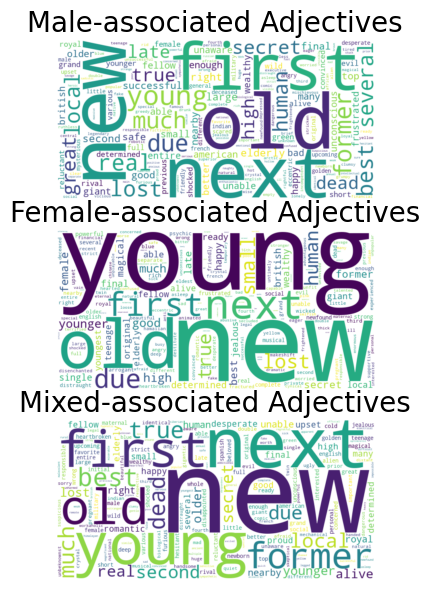

In [30]:
male_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(male_adj))
female_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(female_adj))
plt.figure(figsize=(15, 7))
plt.subplot(3, 1, 1)
plt.title("Male-associated Adjectives", size=20)
plt.imshow(male_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.subplot(3, 1, 2)
plt.title("Female-associated Adjectives", size=20)
plt.imshow(female_wordcloud, interpolation='bilinear')
plt.axis('off')
mixed_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(mxed_adj))
plt.subplot(3, 1, 3)
plt.title("Mixed-associated Adjectives", size=20)
plt.imshow(mixed_wordcloud, interpolation='bilinear')
plt.axis('off') 
plt.show()

(np.float64(-0.5), np.float64(799.5), np.float64(399.5), np.float64(-0.5))

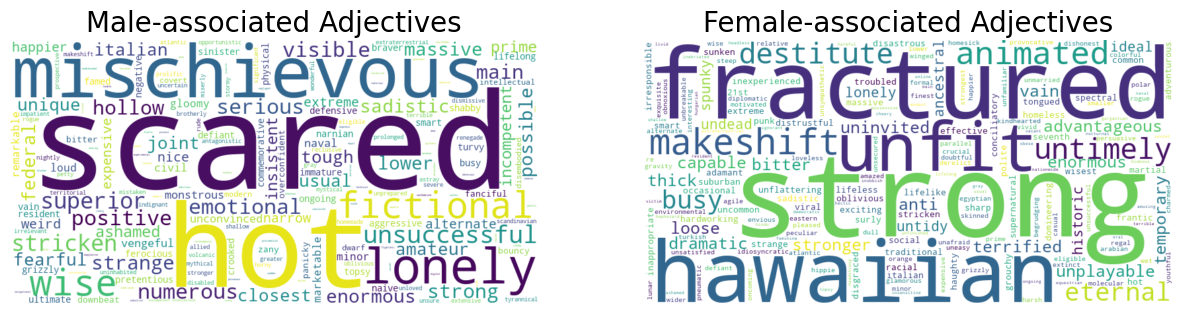

In [32]:
cleaned_male_adj = [adj for adj in male_adj if adj not in mixed_adj]
cleaned_female_adj = [adj for adj in female_adj if adj not in mixed_adj]    
male_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(cleaned_male_adj))
female_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(cleaned_female_adj))
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.title("Male-associated Adjectives", size=20)
plt.imshow(male_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Female-associated Adjectives", size=20)
plt.imshow(female_wordcloud, interpolation='bilinear')
plt.axis('off')


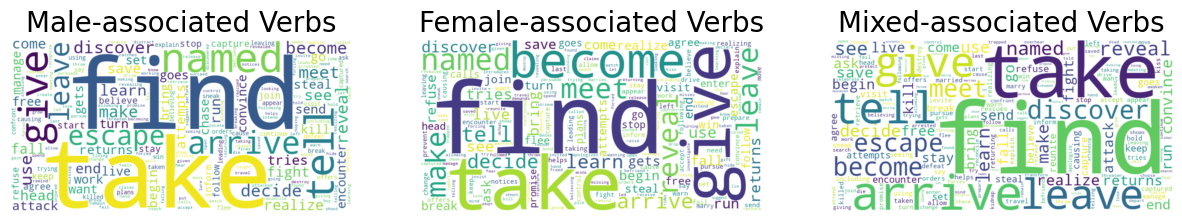

In [33]:
male_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(male_verbs))
female_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(female_verbs))
mixed_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(mixed_verbs))
plt.figure(figsize=(15, 7))
plt.subplot(1, 3, 1)
plt.title("Male-associated Verbs", size=20)
plt.imshow(male_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.title("Female-associated Verbs", size=20)
plt.imshow(female_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.title("Mixed-associated Verbs", size=20)
plt.imshow(mixed_wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

(np.float64(-0.5), np.float64(799.5), np.float64(399.5), np.float64(-0.5))

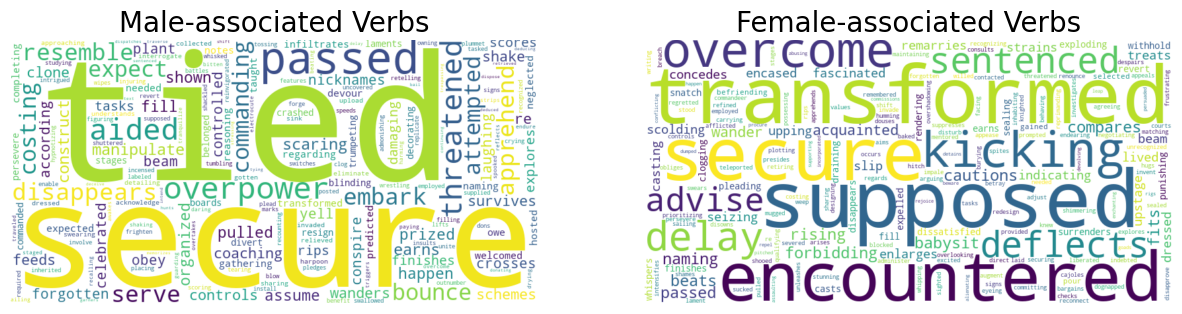

In [34]:
cleaned_male_verbs = [verb for verb in male_verbs if verb not in mixed_verbs]
cleaned_female_verbs = [verb for verb in female_verbs if verb not in mixed_verbs]    
male_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(cleaned_male_verbs))
female_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(cleaned_female_verbs))
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.title("Male-associated Verbs", size=20)
plt.imshow(male_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Female-associated Verbs", size=20)
plt.imshow(female_wordcloud, interpolation='bilinear')
plt.axis('off')

In [35]:
from collections import Counter
import numpy as np

male_counts = Counter(male_adj)
female_counts = Counter(female_adj)

# Total adjectives for each gender
N_male = sum(male_counts.values())
N_female = sum(female_counts.values())

# Add a prior (Dirichlet smoothing)
alpha = 0.01  

scores = {}

all_adj = set(male_counts) | set(female_counts)

for adj in all_adj:
    c_m = male_counts[adj]
    c_f = female_counts[adj]

    p_m = (c_m + alpha) / (N_male + alpha * len(all_adj))
    p_f = (c_f + alpha) / (N_female + alpha * len(all_adj))

    # Log-odds score
    scores[adj] = np.log(p_m) - np.log(p_f)


In [36]:
male_top = sorted(scores.items(), key=lambda x: -x[1])[:20]
female_top = sorted(scores.items(), key=lambda x: x[1])[:20]
print("Top 20 male-associated adjectives:")
for adj, score in male_top:
    print(f"{adj}: {score:.4f}")
print("\nTop 20 female-associated adjectives:")
for adj, score in female_top:
    print(f"{adj}: {score:.4f}") 


Top 20 male-associated adjectives:
top: 6.7934
green: 6.2827
reluctant: 6.2402
general: 6.1958
scared: 6.1005
favorite: 5.9381
comic: 5.8775
rid: 5.8775
huge: 5.8775
drunk: 5.8130
african: 5.7440
mischievous: 5.7440
fictional: 5.6700
executive: 5.6700
tired: 5.5900
newborn: 5.5900
rightful: 5.5900
arctic: 5.5900
grumpy: 5.5900
central: 5.5031

Top 20 female-associated adjectives:
psychic: -7.8995
fractured: -7.7175
hawaiian: -7.4949
disenchanted: -7.4949
pregnant: -7.4949
unplayable: -7.2080
thick: -7.2080
16th: -7.2080
advantageous: -7.2080
uninvited: -7.2080
pink: -7.2080
untidy: -6.8042
edwardian: -6.8042
rambunctious: -6.8042
lifeless: -6.8042
spunky: -6.8042
racial: -6.8042
uncommon: -6.8042
haughty: -6.8042
deadly: -6.8042


In [ ]:
def detect_communities(graph):
    partition = community_louvain.best_partition(graph)

    num_communities = len(set(partition.values()))
    print(f"Number of communities detected: {num_communities}")

    partition_sizes = Counter(partition.values())
    largest_partitions = partition_sizes.most_common(5)

    print("Sizes of the 5 largest communities:")
    print(sorted(largest_partitions, key=lambda x: x[1], reverse=True))

    return partition  # useful if you want to visualize later
m_communities = detect_communities(m_largest)
f_communities = detect_communities(f_largest)

#try modularity algorithm to detect communities

Number of communities detected: 24
Sizes of the 5 largest communities:
[(1, 1379), (2, 1222), (13, 1110), (17, 756), (11, 642)]
Number of communities detected: 26
Sizes of the 5 largest communities:
[(21, 424), (9, 383), (8, 375), (11, 364), (16, 339)]


In [ ]:
#wordcloud for each community
